In [13]:
import numpy
%matplotlib notebook
from matplotlib import pyplot

In [91]:
from soapy import atmosphere, WFS, confParse
from aotools import circle
from aotools.wfs import wfslib

In [15]:
SOAPY_CONF = "conf/test_conf.py"

In [88]:
def scaleScrnR0(scrns, oldR0, newR0):
    r0Scrns = scrns.copy() * ((oldR0/newR0)**(5./6.))
    return r0Scrns

In [16]:
# Initialise the WFS
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()

mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)

wfs = WFS.ShackHartmann(
        config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

In [121]:
# Make a set of phase screens to test
nScrns = 20
nSub = 4
scrnSize = config.sim.simSize*nSub
simSize = config.sim.simSize

# r0 to make scrns initially
scrn_r0 = 1.
pxlScale = 1./config.sim.pupilSize
L0 = 100
l0 = 0.01

# Make all the phase screens
scrns = numpy.zeros((nScrns*nSub*nSub, simSize, simSize))
for i in range(nScrns):
    wholeScrn = atmosphere.ft_sh_phase_screen(scrn_r0, scrnSize, pxlScale, L0, l0)
    for nx in range(nSub):
        for ny in range(nSub):
            index = i*(nSub**2) + nx*nSub + ny
            scrns[index] = wholeScrn[nx*simSize:(nx+1)*simSize, ny*simSize:(ny+1)*simSize]


In [122]:
scrns *= 500./(2*numpy.pi)
print(scrns.min(), scrns.max(), scrns.var())

(-751.67310592083743, 500.96671515878188, 24029.320327716749)


In [123]:
# Get slopes for each screen, for each r0
nR0 = 10
r0s = numpy.linspace(0.05, scrn_r0, nR0)
slopes = numpy.zeros((nR0, len(scrns), wfs.activeSubaps*2))

for ir, r0 in enumerate(r0s):
    r0Scrns = scaleScrnR0(scrns, 1, r0)
    print(r0, r0Scrns.var())
    for i, s in enumerate(r0Scrns):
        slopes[ir, i] = wfs.frame(s)

(0.050000000000000003, 3540990.9191291267)
(0.15555555555555556, 534070.93446603534)
(0.26111111111111113, 225267.85939227976)
(0.36666666666666664, 127925.10128770216)
(0.47222222222222221, 83913.297152419051)
(0.57777777777777783, 59952.426213594474)
(0.68333333333333335, 45326.669543010328)
(0.78888888888888897, 35676.45998681894)
(0.89444444444444449, 28939.156517353829)
(1.0, 24029.320327716749)


In [134]:
for i in range(nR0):
    print(slopes[i].min(), slopes[i].max(), slopes[i].var())

(-2.9341454946265282, 2.501007819159943, 0.38684439449225128)
(-1.1857627553938634, 0.97845860750556213, 0.062526366858002544)
(-0.7590400417684986, 0.65531108681927996, 0.028214087666972448)
(-0.58223888355922426, 0.43977571410347238, 0.016944761549637283)
(-0.44755239456256746, 0.39828180796667034, 0.011551559756433178)
(-0.36879880042655344, 0.32128440676965653, 0.0084648564321565204)
(-0.33695472459946529, 0.2899580409092124, 0.0065086690339607421)
(-0.30921237019576786, 0.26384211165341931, 0.0051814161737302293)
(-0.28528820364268803, 0.24196028371870426, 0.0042367663577193076)
(-0.26464565610502966, 0.22345486604165643, 0.0035387526223509035)


In [125]:
# Turn slopes into radians
wfsPxlScale_asec = float(config.wfss[0].subapFOV)/config.wfss[0].pxlsPerSubap
wfsPxlScale_deg = wfsPxlScale_asec/3600.
wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
print(wfsPxlScale_rad)

6.06017101387e-07


In [139]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad

In [168]:
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(nR0)
for i in range(nR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


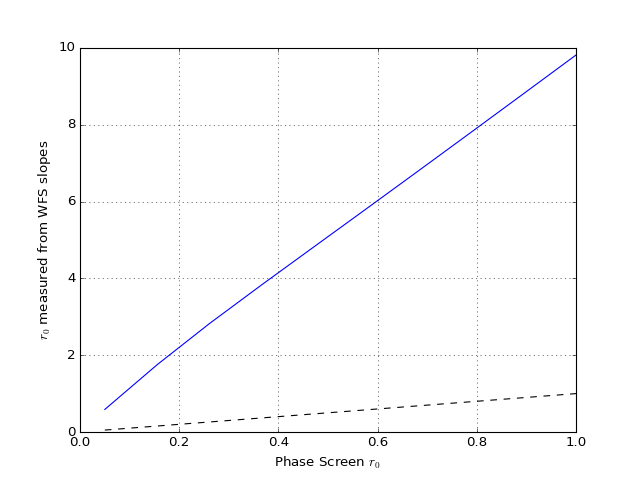

In [169]:
pyplot.figure()
pyplot.plot(r0s, measuredR0)
pyplot.plot(r0s, r0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [150]:
slopes_rad[1].var(0).mean()

2.2895475648524036e-14

In [146]:
wfs.activeSubaps

52

In [166]:
nScrns = 100

# Alternative way, which uses Soapy atmosphere
config.atmos.scrnNo = 1
slopes = numpy.zeros((nR0, nScrns, wfs.activeSubaps*2))
for ir, r0 in enumerate(r0s):
    config.atmos.r0 = r0
    config.atmos.randomScrns = True
    atmos = atmosphere.atmos(config.sim, config.atmos)
    for i in range(nScrns):
        slopes[ir, i] = wfs.frame(atmos.moveScrns())

In [167]:
slopes.shape

(10, 100, 104)

In [170]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(nR0)
for i in range(nR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


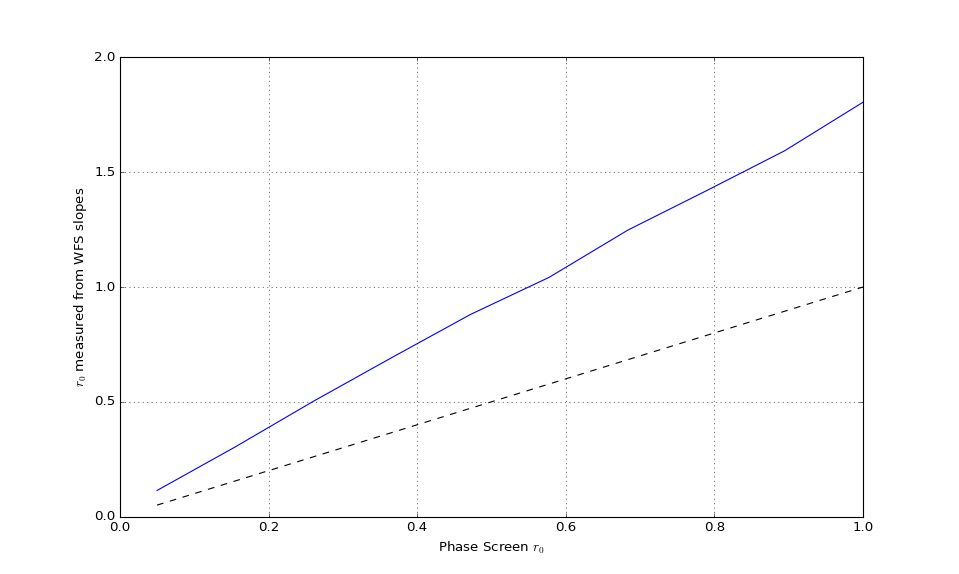

In [171]:
pyplot.figure()
pyplot.plot(r0s, measuredR0)
pyplot.plot(r0s, r0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [173]:
# Perhaps this is something to do with WFS linearity? Would see a change with pixel scale if so
nFovs = 5
subapFovs = numpy.linspace(3, 10, nFovs)
nScrns = 100

# Alternative way, which uses Soapy atmosphere
config.atmos.scrnNo = 1

slopes = numpy.zeros((nFovs, nR0, nScrns, wfs.activeSubaps*2))

for ifov, fov in enumerate(subapFovs):
    config.wfss[0].subapFOV = fov
    wfs = WFS.ShackHartmann(
        config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)
    for ir, r0 in enumerate(r0s):
        config.atmos.r0 = r0
        config.atmos.randomScrns = True
        atmos = atmosphere.atmos(config.sim, config.atmos)
        for i in range(nScrns):
            slopes[ifov, ir, i] = wfs.frame(atmos.moveScrns())

WFS.py -> initFFTs: requested WFS FFT Padding less than FOV size... Setting oversampling to: 4
WFS.py -> initFFTs: requested WFS FFT Padding less than FOV size... Setting oversampling to: 5


In [176]:
wfsPxlScales_rad = []
slopes_rad = slopes.copy()
# Turn slopes into radians
for ifov, fov in enumerate(subapFovs):
    wfsPxlScale_asec = float(fov)/config.wfss[0].pxlsPerSubap
    wfsPxlScale_deg = wfsPxlScale_asec/3600.
    wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
    
    slopes_rad[ifov] *= wfsPxlScale_rad
    print(wfsPxlScale_rad)

7.27220521664e-07
9.15759175429e-07
1.10429782919e-06
1.29283648296e-06
1.48137513672e-06
1.66991379049e-06
1.85845244425e-06
2.04699109802e-06
2.23552975178e-06
2.42406840555e-06


In [178]:
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros((nFovs, nR0))
for ifov, fov in enumerate(subapFovs):
    for i in range(nR0):
        sVar = slopes_rad[ifov, i].var(0).mean()
        measuredR0[ifov, i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


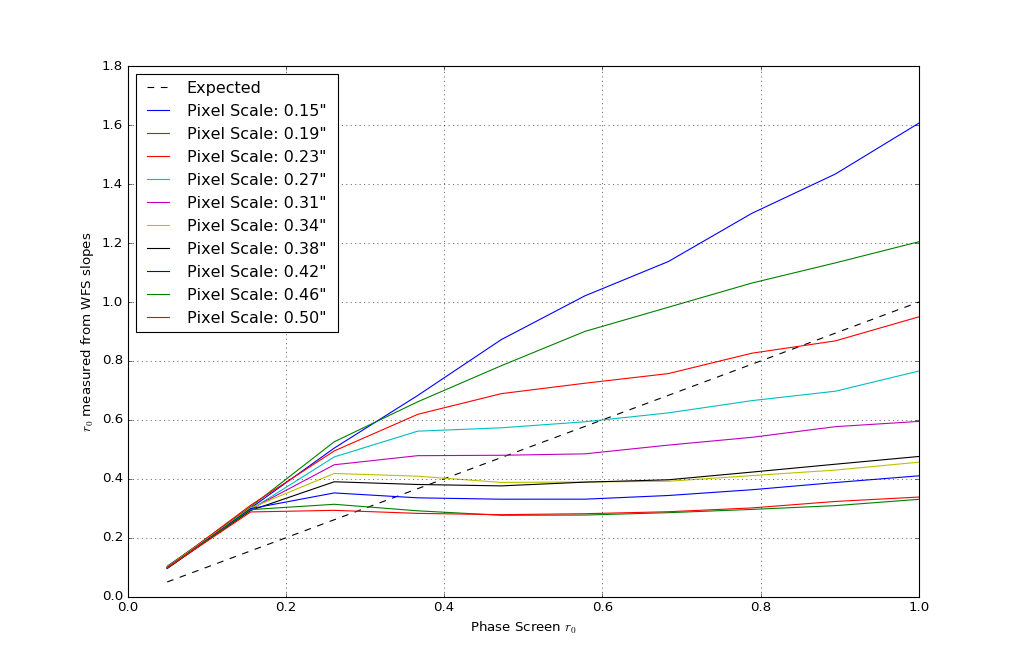

In [185]:
pyplot.figure()
pyplot.plot(r0s, r0s, color="k", linestyle="--", label="Expected")

pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

for ifov, fov in enumerate(subapFovs):
    pxlScale = float(fov)/config.wfss[0].pxlsPerSubap
    pyplot.plot(r0s, measuredR0[ifov], label="Pixel Scale: {:.2f}\" ".format(pxlScale))
    
pyplot.legend(loc=0)